In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##### Leer el conjunto de datos

In [4]:
df = pd.read_csv('../data/titanic.csv', sep=';', decimal=",")

In [5]:
# numero de filas y columnas
df.shape

(1309, 11)

In [6]:
# tipos de cada columna
df.dtypes

pclass        int64
survived      int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

In [7]:
# primeras 5 filas
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,2,1,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
1,2,1,"Wilhelms, Mr. Charles",male,31.0,0,0,244270,13.0000,NaN,S
2,3,0,"Heininen, Miss. Wendla Maria",female,23.0,0,0,STON/O2. 3101290,7.9250,NaN,S
3,3,0,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S
4,1,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0000,B52 B54 B56,S


##### Hacer un gráfico de barras con el número de pasajeros que han muerto y los que han sobrevivido por género

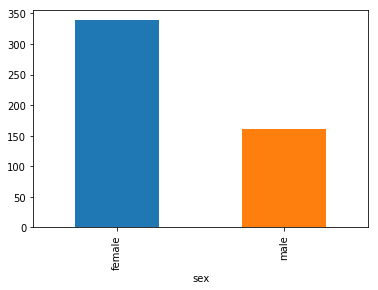

In [8]:
# pasajeros que han sobrevivido
df.groupby('sex')['survived'].sum().plot(kind='bar');

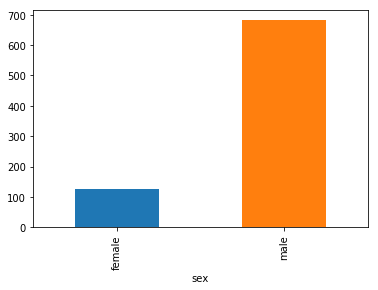

In [9]:
# si queremos los que han muerto, podemos negar con ~ (not logico en Series) la columna survived
# hay que tener en cuenta que son enteros, por lo que hay que especificar que es booleana primero
(~df['survived'].astype(bool)).groupby(df['sex']).sum().plot(kind='bar');

In [10]:
# Si queremos ambos gráficos en uno, se puede agrupar por las dos variables y contar
# Las siguientes dos líneas son equivalentes
df.groupby(['sex', 'survived']).size()
df.groupby(['sex', 'survived']).apply(len)

sex     survived
female  0           127
        1           339
male    0           682
        1           161
dtype: int64

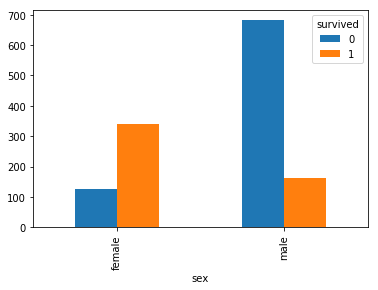

In [11]:
# El metodo unstack() quita un nivel del índice jerárquico y lo pone como columnas
df.groupby(['sex', 'survived']).size().unstack().plot(kind='bar');

##### Hacer un gráfico de barras con el número de personas que sobrevivieron en cada grupo de edad (0-10, 11-20, 21-30, etc) 

In [12]:
df['age_cat'] = pd.cut(df['age'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

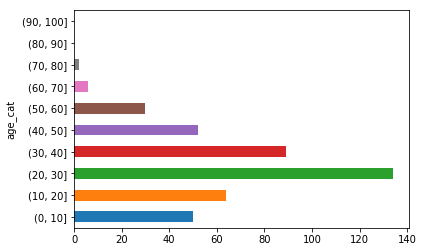

In [13]:
# sort_index() ordena el índice
# en el gráfico vemos que no hay ninguna persona de más de 80 años
df.groupby('age_cat')['survived'].sum().plot(kind='barh');

##### Calcular la probabilidad de supervivencia en base al sexo y a la clase

In [14]:
df.groupby(['sex', 'pclass'])['survived'].mean()

sex     pclass
female  1         0.965278
        2         0.886792
        3         0.490741
male    1         0.340782
        2         0.146199
        3         0.152130
Name: survived, dtype: float64

##### Calcular la probabilidad de supervivencia en base la edad, al título y a la clase

Primero vamos a calcular el título, que venía de otro ejercicio. La primera aproximación que vimos en clase es el método `str.split()`

In [15]:
df['title'] = df['name'].str.split(" ", n=2, expand=True)[1]
df['title'].value_counts()

Mr.             736
Miss.           256
Mrs.            191
Master.          59
Dr.               8
y                 8
Rev.              8
Planke,           4
Col.              4
Impe,             3
Billiard,         3
Carlo,            2
Messemaeker,      2
Major.            2
Gordon,           2
Mlle.             2
Ms.               2
Mulder,           1
Cruyssen,         1
Khalil,           1
der               1
Jonkheer.         1
Don.              1
Palmquist,        1
Capt.             1
Mme.              1
Velde,            1
Shawah,           1
Pelsmaeker,       1
Steen,            1
the               1
Brito,            1
Melkebeke,        1
Walle,            1
Name: title, dtype: int64

Vemos que falla para apellidos compuestos como por ejemplo "de Brito" o "Penasco y Castellana", devolviendo respectivamente como título "Brito" e "y". También falla para títulos compuestos como "the Countess". En la siguiente celda podemos ver los nombres que se están asociando al título "y"

In [16]:
idx = np.flatnonzero(df['title'] == 'y')
df['name'][idx]

191                        Duran y More, Miss. Florentina
206     Penasco y Castellana, Mrs. Victor de Satode (M...
207                          Duran y More, Miss. Asuncion
215                         Pallas y Castello, Mr. Emilio
273                            Padro y Manent, Mr. Julian
354                          Oliva y Ocana, Dona. Fermina
472                       Ovies y Rodriguez, Mr. Servando
1231           Penasco y Castellana, Mr. Victor de Satode
Name: name, dtype: object

Vamos a probar ahora con el método `.str.extract()`, que toma como argumento una expresión regular. En este caso la expresión "ignora cualquier carácter hasta `','` y después selecciona cualquier carácter entre `','` y `'.'`. La sintáxis de las expresiones regulares se puede ver en la documentación: https://docs.python.org/2/library/re.html

In [17]:
df['title'] = df['name'].str.extract('.*, (.*)\. .*', expand=False)
df['title'].value_counts()

Mr                          757
Miss                        260
Mrs                         196
Master                       61
Dr                            8
Rev                           8
Col                           4
Mlle                          2
Ms                            2
Major                         2
the Countess                  1
Lady                          1
Jonkheer                      1
Dona                          1
Capt                          1
Mrs. Martin (Elizabeth L      1
Don                           1
Mme                           1
Sir                           1
Name: title, dtype: int64

Ahora vemos que tiene mucha mejor pinta, pero sigue fallando para un caso, `Rothschild, Mrs. Martin (Elizabeth L. Barrett)`. El motivo es que en dicho nombre aparece otro `'.'` y el `*` es avaricioso, cogiendo todos los caracteres hasta el segundo `'.'`.

In [18]:
df['name'][df['title'].str.contains('Mrs. Martin')]

1105    Rothschild, Mrs. Martin (Elizabeth L. Barrett)
Name: name, dtype: object

Por tanto, tenemos que cambiar ligeramente la expresión regular para usar el operador `*?`, que es la versión no avariciosa y se para en la primera ocurrencia de `'.'`. Abajo podemos ver que hay títulos que contienen muy pocas personas. En un ejemplo real probablemente los agruparíamos en `'Otros'`. De la misma forma hay versiones francesas de `'Miss'` y `'Mrs'` que habría que normalizar. Para este ejercicio vamos a dejarlos así.

In [19]:
df['title'] = df['name'].str.extract('.*, (.*?)\. .*', expand=False)
df['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Sir               1
Lady              1
the Countess      1
Capt              1
Dona              1
Don               1
Mme               1
Jonkheer          1
Name: title, dtype: int64

Por último, calculamos la probabilidad de supervivencia por sexo, clase y título.

In [20]:
df.groupby(['sex', 'pclass', 'title'])['survived'].mean()

sex     pclass  title       
female  1       Dona            1.000000
                Dr              1.000000
                Lady            1.000000
                Miss            0.950000
                Mlle            1.000000
                Mme             1.000000
                Mrs             0.974026
                the Countess    1.000000
        2       Miss            0.940000
                Mrs             0.836364
                Ms              1.000000
        3       Miss            0.480000
                Mrs             0.523077
                Ms              0.000000
male    1       Capt            0.000000
                Col             0.500000
                Don             0.000000
                Dr              0.600000
                Jonkheer        0.000000
                Major           0.500000
                Master          1.000000
                Mr              0.308176
                Sir             1.000000
        2       Dr          

##### Completar ahora los valores que faltan de la edad con la mediana pero agrupada por título y clase

Esta parte se puede hacer de varias formas, pero en una línea sería:

In [21]:
df['newage'] = df.groupby(['pclass', 'title'])['age'].transform(lambda x: x.fillna(x.median()))

Otra forma, primero calculamos la mediana agrupada pero manteniendo el índice de las filas original (`.transform()`)

In [22]:
grouped_median = df.groupby(['pclass', 'title'])['age'].transform('median')
df['newage'] = df['age'].fillna(grouped_median)
grouped_median

0       30.0
1       30.0
2       18.0
3       18.0
4       41.5
5       30.0
6       26.0
7       26.0
8       31.0
9       18.0
10      30.0
11      26.0
12      20.0
13      18.0
14       6.0
15      26.0
16      26.0
17      20.0
18      30.5
19      45.0
20      30.0
21      31.0
22      26.0
23      31.0
24      31.0
25      30.0
26      26.0
27      20.0
28      26.0
29      24.0
        ... 
1279    20.0
1280    26.0
1281    45.0
1282     2.0
1283    30.5
1284    30.5
1285    31.0
1286    45.0
1287    45.0
1288    30.0
1289    30.0
1290    30.0
1291    26.0
1292    41.5
1293    30.0
1294    30.0
1295     6.0
1296    45.0
1297    26.0
1298    41.5
1299    30.5
1300    26.0
1301    28.0
1302    49.0
1303    26.0
1304    26.0
1305    31.0
1306    41.5
1307    26.0
1308    30.0
Name: age, Length: 1309, dtype: float64

Comprobamos que el resultado es correcto calculando primero la mediana agrupada e inspeccionando visualmente que el valor con el que se han completado los `null` de `age` efectivamente depende de la clase y el título.

In [23]:
df.groupby(['pclass', 'title'])['age'].median()

pclass  title       
1       Capt            70.0
        Col             54.5
        Don             40.0
        Dona            39.0
        Dr              49.0
        Jonkheer        38.0
        Lady            48.0
        Major           48.5
        Master           6.0
        Miss            30.0
        Mlle            24.0
        Mme             24.0
        Mr              41.5
        Mrs             45.0
        Sir             49.0
        the Countess    33.0
2       Dr              38.5
        Master           2.0
        Miss            20.0
        Mr              30.0
        Mrs             30.5
        Ms              28.0
        Rev             41.5
3       Master           6.0
        Miss            18.0
        Mr              26.0
        Mrs             31.0
        Ms               NaN
Name: age, dtype: float64

In [24]:
# así se puede investigar visualmente que se ha hecho correctamente
df.loc[df['age'].isnull(), ['pclass', 'title', 'newage']]

,pclass,title,newage
11,3,Mr,26.0
13,3,Miss,18.0
24,3,Mrs,31.0
26,3,Mr,26.0
28,3,Mr,26.0
30,3,Miss,18.0
37,1,Mr,41.5
39,3,Mr,26.0
48,1,Mr,41.5
49,3,Mr,26.0


##### Convertir las variables no numéricas en numéricas con .get_dummies()

Primero vamos a ver cuantos valores faltan en cada variable

In [25]:
df.isnull().sum()

pclass         0
survived       0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
age_cat      263
title          0
newage         1
dtype: int64

Quitamos la variable `age` (nos quedamos con `newage`, que no tiene missing), `age_cat`, `cabin` (demasiados missing), `name` (tenemos el título) y `ticket` (tiene un valor distinto para cada fila).

In [26]:
df_clean = df.drop(['age', 'age_cat', 'cabin', 'name', 'ticket'], axis=1)

Aun así, todavía tenemos 4 missing values en nuestros datos. El de `newage` es porque no hay ninguna otra persona en el grupo de `pclass == 3` y `title == Ms`, por tanto no se puede rellenar. Eliminamos esas 4 filas y obtenemos la codificación dummy.

In [27]:
df_clean.loc[df_clean.isnull().any(axis=1), :]

,pclass,survived,sex,sibsp,parch,fare,embarked,title,newage
306,3,0,male,0,0,NaN,S,Mr,60.5
734,1,1,female,0,0,80.00,NaN,Mrs,62.0
1071,3,0,female,0,0,7.75,Q,Ms,NaN
1109,1,1,female,0,0,80.00,NaN,Miss,38.0


In [28]:
df_clean.dropna(how='any', inplace=True)

In [29]:
df_num = pd.get_dummies(df_clean, drop_first=True)
df_num

,pclass,survived,sibsp,parch,fare,newage,sex_male,embarked_Q,embarked_S,title_Col,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,2,1,0,0,10.5000,19.0000,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1,0,0,13.0000,31.0000,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3,0,0,0,7.9250,23.0000,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,3,0,1,1,12.1833,1.0000,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,1,1,0,0,0.0000,49.0000,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5,2,0,0,0,13.0000,32.0000,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
6,3,0,1,3,34.3750,16.0000,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
7,3,0,1,0,14.4542,27.0000,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,3,1,0,2,11.1333,27.0000,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
9,3,1,0,0,8.0292,15.0000,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [30]:
# podemos comprobar que ahora son todas numéricas
df_num.dtypes

pclass                  int64
survived                int64
sibsp                   int64
parch                   int64
fare                  float64
newage                float64
sex_male                uint8
embarked_Q              uint8
embarked_S              uint8
title_Col               uint8
title_Don               uint8
title_Dona              uint8
title_Dr                uint8
title_Jonkheer          uint8
title_Lady              uint8
title_Major             uint8
title_Master            uint8
title_Miss              uint8
title_Mlle              uint8
title_Mme               uint8
title_Mr                uint8
title_Mrs               uint8
title_Ms                uint8
title_Rev               uint8
title_Sir               uint8
title_the Countess      uint8
dtype: object

##### Particionar el conjunto en train/test

Primero separamos la variable a predecir del resto, y luego utilizamos la función `train_test_split` de scikit.

In [31]:
X = df_num.drop('survived', axis=1)
y = df_num['survived']

In [32]:
X.shape

(1305, 25)

In [33]:
y.shape

(1305,)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

##### Normalizar las variables para que tengan media 0 y varianza 1

In [35]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train = std.fit_transform(X_train)
X_test  = std.transform(X_test)

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/alberto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


Comprobamos

In [36]:
X_train.mean(axis=0)

array([-1.14427895e-16, -4.90405262e-17, -5.17649999e-17, -7.99178946e-17,
       -7.26526315e-18,  5.08568420e-17,  7.81015788e-17,  9.26321051e-17,
        2.36121052e-17,  0.00000000e+00,  3.63263157e-18,  1.27142105e-17,
       -1.27142105e-17, -1.08978947e-17,  1.81631579e-18,  4.99486841e-18,
        3.08773684e-17,  0.00000000e+00,  0.00000000e+00, -1.72550000e-16,
       -3.63263157e-18, -1.08978947e-17,  2.54284210e-17,  0.00000000e+00,
       -3.63263157e-18])

In [37]:
X_train.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1.])

Los 0 del vector anterior indican que toda esa columna vale 0. Esto es porque hay títulos que contienen una única persona, y por tanto un solo 1 en el vector de la columna correspondiente. Al partir en train-test, si la observación que contiene el 1 se ha asignado al test va a generar una desviación estándar de 0 en el train. Por tanto, probablemente deberíamos de haber agrupado títulos con poca frecuencia.

##### Ajustar un clasificador RandomForestClassifier() y ver cuantos pasajeros clasifica correctamente en Superviviente/No superviviente

In [38]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
rfc.score(X_train, y_train)

0.9652351738241309

In [40]:
rfc.score(X_test, y_test)

0.7920489296636085

Vemos que el acierto en train es 96%, mientras que en test es 78%. Al utilizar los hyper-parámetros por defecto del Random Forest hemos ajustado un modelo donde se observa bastante *overfitting*. Vamos a intentar corregirlo, al menos parcialmente, haciendo una búsqueda muy sencilla de unos hyper-parámetros mejores.

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':      [50, 100, 150, 200],
              'max_depth':         [None, 3, 5],
              'min_samples_leaf':  [1, 2, 4],
              'min_samples_split': [2, 4, 8]}

cv = GridSearchCV(rfc, param_grid=param_grid, cv=5, return_train_score=False)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 150, 200], 'max_depth': [None, 3, 5], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

Resultados de la búsqueda en rejilla. Para cada conjunto de parámetros tenemos su error de validación cruzada, tasa de acierto media, ranking, etc. El diccionario que devuelve está preparado para cargar dentro de un DataFrame de Pandas.

In [43]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.049522,0.005078,0.007906,0.006273,None,1,2,50,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.790816,0.790816,0.801020,0.764103,0.769231,0.783231,0.014090,107
1,0.083651,0.001850,0.007583,0.000037,None,1,2,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.806122,0.790816,0.801020,0.753846,0.764103,0.783231,0.020618,107
2,0.136908,0.003943,0.011906,0.000361,None,1,2,150,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.801020,0.795918,0.821429,0.769231,0.758974,0.789366,0.022513,104
3,0.172431,0.001342,0.014821,0.000120,None,1,2,200,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.811224,0.785714,0.790816,0.774359,0.769231,0.786299,0.014669,106
4,0.040782,0.000720,0.003975,0.000018,None,1,4,50,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.816327,0.795918,0.811224,0.779487,0.805128,0.801636,0.012980,86
5,0.085360,0.002199,0.007869,0.000141,None,1,4,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.816327,0.801020,0.806122,0.769231,0.805128,0.799591,0.015968,96
6,0.127624,0.003787,0.011449,0.000577,None,1,4,150,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.801020,0.801020,0.801020,0.764103,0.784615,0.790389,0.014573,103
7,0.164256,0.003210,0.014651,0.000128,None,1,4,200,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.806122,0.790816,0.790816,0.764103,0.789744,0.788344,0.013541,105
8,0.040319,0.001367,0.004169,0.000180,None,1,8,50,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.816327,0.806122,0.816327,0.764103,0.815385,0.803681,0.020123,81
9,0.080874,0.003666,0.007707,0.000474,None,1,8,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.826531,0.801020,0.836735,0.753846,0.815385,0.806748,0.028950,60


Mejores parámetros, mejor *accuracy* y mejor modelo:

In [44]:
cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 50}

In [45]:
cv.best_score_

0.8231083844580777

In [46]:
best_rfc = cv.best_estimator_

In [47]:
best_rfc.score(X_train, y_train)

0.8609406952965235

In [48]:
best_rfc.score(X_test, y_test)

0.8012232415902141

Vemos ahora que el error de entrenamiento ha bajado considerablemente pero el de test ha subido, por lo que ya no hay tanta disparidad entre ambos. Si quisieramos calcular otras medidas de clasificación distintas de la *accuracy*, tenemos que obtener explicitamente las predicciones:

In [49]:
y_pred = best_rfc.predict(X_test)

A continuación importamos la función que nos interese, en este ejemplo vamos a ver un reporte con las principales medidas y la matriz de confusión:

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       209
           1       0.77      0.64      0.70       118

   micro avg       0.80      0.80      0.80       327
   macro avg       0.79      0.77      0.77       327
weighted avg       0.80      0.80      0.80       327



In [52]:
confusion_matrix(y_test, y_pred)

array([[187,  22],
       [ 43,  75]])